In [53]:
"""
This example shows how to perform regression of molecular properties with a
database of the atomic geometry of water clusters with an associated energy, 
using a simple GNN in disjoint mode.
"""

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from mendeleev import H, O

# Install matplotlib inside the virtual env
#import pip
#pip.main(["install","matplotlib"])
import matplotlib.pyplot as plt

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.datasets import QM9
from spektral.layers import GCSConv, ECCConv, GlobalSumPool, MessagePassing, GATConv, CrystalConv

#from spektral.utils import normalized_adjacency

In [54]:
################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
#learning_rate = 1e-4  # Learning rate
epochs = 200  # Number of training epochs
batch_size = 1  # Batch size

initial_learning_rate = 1e-3
#learning_rate = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=initial_learning_rate, decay_steps=epochs/10, decay_rate=0.8)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=initial_learning_rate,
                decay_steps=epochs/10, decay_rate=0.8)

"""
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate_initial,
    decay_steps=epochs,
    decay_rate=0.98)
"""


'\nlearning_rate = tf.keras.optimizers.schedules.ExponentialDecay(\n    initial_learning_rate=learning_rate_initial,\n    decay_steps=epochs,\n    decay_rate=0.98)\n'

In [44]:
################################################################################
# Load data and make graphs
################################################################################
class MyDataset(Dataset):
    """
    A dataset of graphs obtained from the atomic positions of water
    clusters with size between 20 and 237 water molecules, each of them
    associated to an energy value.
    """

    def __init__(self, r2_cutoff, n_dim = 3, **kwargs):

        self.r2_cutoff = r2_cutoff
        self.n_dim = n_dim

        # path of the atomic geometry files
        self.geometry_paths = []
        #data_dir = "../dataset_WaterClusters_big/"
        data_dir = "../dataset_WaterClusters/"
        #for N in [20,32,47,76,100,139,190,237]:
            #for temp in [100,150,200]:
                #for MDstep in ["0500.dat","1000.dat","1500.dat","2000.dat"]:
                    #geometry_path = data_dir+"N"+str(N)+"-T"+str(temp)+"/"+str(MDstep)
                    #self.geometry_paths.append(geometry_path)
        for folder in os.listdir(data_dir): 
            dir_name = os.path.join(data_dir,folder)
            for file_name in os.listdir(dir_name):
                geometry_path = os.path.join(dir_name,file_name)
                self.geometry_paths.append(geometry_path)

        self.n_samples = len(self.geometry_paths)

        self.Epm_avrg = 0.0
        self.Epm_dev = 0.0
        self.E_avrg = 0.0
        self.E_dev = 0.0
        self.xmax = 22.0

        self.num_node_features = 0
        self.num_edge_features = 0
        self.num_labels = 0
        
        super().__init__(**kwargs)

    def read(self):

        def compute_Eavrg():

            # Compute the average energy per molecule among all the clusters

            Epm_avrg = 0.0
            E_avrg = 0.0
            
            for ii in range(self.n_samples):
            
                geom_path = self.geometry_paths[ii]
                gfile = open(geom_path,'r')
                line = gfile.readline()
                n_molecules = int(gfile.readline())
                line = gfile.readline()
                line = gfile.readline()
                line = gfile.readline()
                columns = line.split()
                energy = float(columns[0])
                gfile.close()

                Epm_avrg = Epm_avrg + energy / float(n_molecules)
                E_avrg = E_avrg + energy

            Epm_avrg = Epm_avrg / float(self.n_samples)
            E_avrg = E_avrg / float(self.n_samples)

            self.Epm_avrg = Epm_avrg
            self.E_avrg = E_avrg

            print("E_avrg: "+str(E_avrg))

        def compute_Edev():

            # Compute standard deviation from Epm_avrg

            Epm_dev = 0.0
            E_dev = 0.0

            for ii in range(self.n_samples):
            
                geom_path = self.geometry_paths[ii]
                gfile = open(geom_path,'r')
                line = gfile.readline()
                n_molecules = int(gfile.readline())
                line = gfile.readline()
                line = gfile.readline()
                line = gfile.readline()
                columns = line.split()
                energy = float(columns[0])
                gfile.close()

                Epm_dev = Epm_dev + ( energy / float(n_molecules) - self.Epm_avrg )**2
                E_dev = E_dev + ( energy - self.E_avrg )**2

            Epm_dev = np.sqrt( Epm_dev / float(self.n_samples) )
            E_dev = np.sqrt( E_dev / float(self.n_samples) )

            self.Epm_dev = Epm_dev
            self.E_dev = E_dev

            print("E_dev: "+str(E_dev))
            
        def make_graph(isample):

            # Process the header of the geometry file
            geom_path = self.geometry_paths[isample]
            gfile = open(geom_path,'r')
            line = gfile.readline()
            n_molecules = int(gfile.readline())
            line = gfile.readline()
            line = gfile.readline()
            line = gfile.readline()
            columns = line.split()
            energy = float(columns[0])
            line = gfile.readline()
            line = gfile.readline()            

            # Node features (atom type and position [x,y,z])            
            n_nodes = 3*n_molecules
            #num_node_features = 1 + self.n_dim
            num_physical_features = 7
            num_abstract_features = 7
            num_node_features = num_physical_features + num_abstract_features
            self.num_node_features = num_node_features
            x = np.zeros((n_nodes, num_node_features))
            pos = np.zeros((n_nodes, 3))
            for inode in range(n_nodes):
                line = gfile.readline()
                columns = line.split()
                if (inode%3==0): # oxygen atom
                    #x[inode,0] = 1.0   
                    x[inode,0] = O.atomic_number
                    x[inode,1] = O.atomic_radius
                    x[inode,2] = O.covalent_radius
                    x[inode,3] = O.vdw_radius
                    x[inode,4] = O.dipole_polarizability
                    x[inode,5] = O.electron_affinity
                    x[inode,6] = O.en_pauling 
                else:            # hydrogen atom
                    #x[inode,0] = 0.0    
                    x[inode,0] = H.atomic_number
                    x[inode,1] = H.atomic_radius
                    x[inode,2] = H.covalent_radius
                    x[inode,3] = H.vdw_radius
                    x[inode,4] = H.dipole_polarizability
                    x[inode,5] = H.electron_affinity
                    x[inode,6] = H.en_pauling
                pos[inode,0:] = columns[1:]
                #x[inode,1:] = pos[inode,0:]
                #x[inode,1:] = x[inode,1:] / float(self.xmax)
                x[inode,1:] = np.random.random(num_abstract_features)
            gfile.close()                

            # Binary Adjacency matrix (two nodes/atoms are connected if rij2 < r2_cutoff)
            a = np.zeros((n_nodes,n_nodes))
            n_edges = 0
            for iatom in range(3*n_molecules):
                for jatom in range(iatom+1,3*n_molecules):
                    rij = pos[iatom,0:] - pos[jatom,0:]
                    r2 = np.dot(rij,rij)
                    if (r2 <= self.r2_cutoff):
                        #print(iatom,jatom,r2)                        
                        #a[iatom,jatom] = np.sqrt(r2)
                        a[iatom,jatom] = 1
                        n_edges = n_edges + 1            
            a = np.maximum(a, a.T)#.astype(int) # Adjacency matrix is symetric in this case
            a = sp.csr_matrix(a)
            #a = normalized_adjacency(a, symmetric=True)

            # Edge features (type of bonding: O-O, H-O, H-H)
            n_edges = n_edges*2
            num_abstract_features = 10
            num_edge_features = 1 + num_abstract_features
            self.num_edge_features = num_edge_features
            e = np.zeros((n_edges,num_edge_features))
            id_edge = 0
            for iatom in range(3*n_molecules):
                for jatom in range(3*n_molecules):
                    if(iatom!=jatom):
                        rij = pos[iatom,0:] - pos[jatom,0:]
                        r2 = np.dot(rij,rij)
                        if (r2 <= self.r2_cutoff):
                            #print(iatom,jatom,r2)                        
                            e[id_edge,0] = np.sqrt(r2)
                            e[id_edge,1:] = np.random.random(num_abstract_features)
                            id_edge = id_edge + 1
            
            # Labels
            num_labels = 1
            self.num_labels = num_labels
            y = np.zeros(num_labels,)
            y[0,] = energy
            #y[0,] = ( energy / float(n_molecules) - self.Epm_avrg ) / self.Epm_avrg
            #y[0,] = ( energy / float(n_molecules) - self.Epm_avrg ) / self.Epm_dev
            #y[0,] = ( energy - self.E_avrg ) / self.E_dev
            #y[0,] = energy - self.E_avrg
            #y[0,] = ( energy - self.E_avrg ) / self.E_dev * 100
            #y[0,] = energy * 100

            print(str(geom_path)+"    Energy "+str(y[0,]))
            
            return Graph(x=x, a=a, e=e, y=y)

        # Compute average of the energy per molecule
        compute_Eavrg()
        compute_Edev()
        # We must return a list of Graph objects
        return [make_graph(isample) for isample in range(self.n_samples)]        

# Generate dataset from atomic geometry files
#d2_cutoff = 20.0
d2_cutoff = 10.0            
dataset = MyDataset( d2_cutoff )

# Parameters
F = dataset.num_node_features  # Dimension of node features
S = dataset.num_edge_features  # Dimension of edge features
n_out = dataset.num_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.8 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1)
# we set epochs=epochs within loader_te to check loss on test set
#loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=epochs+1)


E_avrg: -1.6378342438541669
E_dev: 1.2369982465197895
../dataset_WaterClusters/N20-T150/0500.dat    Energy -0.25955347
../dataset_WaterClusters/N20-T150/2000.dat    Energy -0.25603255
../dataset_WaterClusters/N20-T150/1500.dat    Energy -0.25106678
../dataset_WaterClusters/N20-T150/1000.dat    Energy -0.24915115
../dataset_WaterClusters/N32-T150/0500.dat    Energy -0.40419989
../dataset_WaterClusters/N32-T150/2000.dat    Energy -0.38739953
../dataset_WaterClusters/N32-T150/1500.dat    Energy -0.41271231
../dataset_WaterClusters/N32-T150/1000.dat    Energy -0.37491919
../dataset_WaterClusters/N100-T150/0500.dat    Energy -1.53129312
../dataset_WaterClusters/N100-T150/2000.dat    Energy -1.54345203
../dataset_WaterClusters/N100-T150/1500.dat    Energy -1.53537838
../dataset_WaterClusters/N100-T150/1000.dat    Energy -1.52608644
../dataset_WaterClusters/N237-T200/0500.dat    Energy -3.70336594
../dataset_WaterClusters/N237-T200/2000.dat    Energy -3.70337252
../dataset_WaterClusters/N237-

In [45]:
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        #self.conv1 = ECCConv(32, activation="relu")
        #self.conv2 = ECCConv(32, activation="relu")
        #self.conv1 = GCSConv(32, activation="relu")
        #self.conv2 = GCSConv(32, activation="relu")
        #self.conv1 = GCSConv(64, activation="tanh")
        #self.conv2 = GCSConv(64, activation="tanh")
        #self.conv3 = GCSConv(64, activation="tanh")
        self.conv1 = CrystalConv(aggregate="sum",activation="sigmoid")
        self.conv2 = CrystalConv(aggregate="sum",activation="sigmoid")
        #self.conv1 = GATConv(8,attn_heads=7,dropout_rate=0)
        #self.conv2 = GATConv(8,attn_heads=7,dropout_rate=0)
        #self.global_pool = GlobalSumPool()
        self.dense1 = Dense(128)
        self.dense2 = Dense(128)
        self.dense3 = Dense(F)
        self.global_pool = GlobalSumPool()
        #self.global_pool = GlobalAttnSumPool()
        #self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        #x, a, i = inputs
        #x = self.conv1([x, a])
        #x = self.conv2([x, a])
        #x = self.conv3([x, a])
        #output = self.global_pool([x, i])
        output = self.dense1(x)
        output = self.dense2(output)
        output = self.dense3(output)
        output = self.global_pool([output, i])
        #output = self.dense(output)

        return output

model = Net()
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()
#loss_fn = MeanAbsoluteError()
#loss_fn = MeanAbsolutePercentageError()

1 Loss: 13531.232421875
2 Loss: 48.508907318115234
3 Loss: 16.505897521972656
4 Loss: 16.531232833862305
5 Loss: 13.798192024230957
6 Loss: 13.45300006866455
7 Loss: 12.977912902832031
8 Loss: 12.74665355682373
9 Loss: 12.720346450805664
10 Loss: 12.648289680480957
11 Loss: 12.64312744140625
12 Loss: 12.635168075561523
13 Loss: 12.631616592407227
14 Loss: 12.63022518157959
15 Loss: 12.630046844482422
16 Loss: 12.630020141601562
17 Loss: 12.630012512207031
18 Loss: 12.630008697509766
19 Loss: 12.630009651184082
20 Loss: 12.630008697509766
21 Loss: 12.630009651184082
22 Loss: 12.63000774383545
23 Loss: 12.63000774383545
24 Loss: 12.630010604858398
25 Loss: 12.630010604858398
26 Loss: 12.63000774383545
27 Loss: 12.630009651184082
28 Loss: 12.630011558532715
29 Loss: 12.63000774383545
30 Loss: 12.630010604858398
31 Loss: 12.630008697509766
32 Loss: 12.630009651184082
33 Loss: 12.630009651184082
34 Loss: 12.63000774383545
35 Loss: 12.63000774383545
36 Loss: 12.630012512207031
37 Loss: 12.63

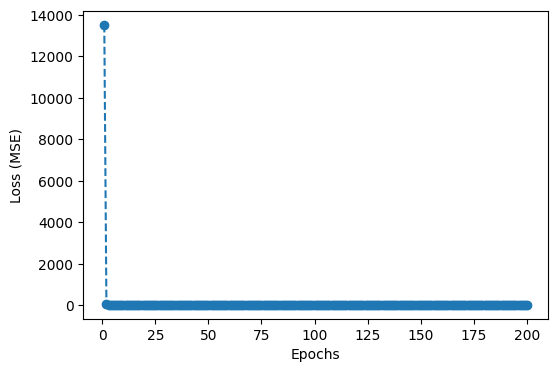

'\n# Plot Loss Function on Test Set\nplt.figure(figsize=(6,4))\nplt.scatter(range(1,epochs+1),loss_test)\nplt.plot(range(1,epochs+1),loss_test,ls="--")\nplt.xlabel("Epochs")\nplt.ylabel("Loss (MSE)")\nplt.show()\n'

In [46]:
################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

outfile = open("loss.dat",'w')
nepoch = 1
step = loss = 0
loss_train = []
#loss_test = []
#loss_te = 0
for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print(str(nepoch)+" Loss: {}".format(loss / loader_tr.steps_per_epoch))
        outfile.write(str(nepoch)+" {}".format(loss / loader_tr.steps_per_epoch)+" \n")
        loss_train.append(loss / loader_tr.steps_per_epoch)
        nepoch = nepoch + 1

        # log the loss into wandb
        #wandb.log({"loss": loss / loader_tr.steps_per_epoch})
        
        loss = 0

        """
        # Loss on test set
        batch_te = next(iter(loader_te))
        inputs, target = batch_te
        predictions = model(inputs, training=False)
        #loss_te += loss_fn(target, predictions)
        loss_te = loss_fn(target, predictions)
        #loss_te /= loader_te.steps_per_epoch
        loss_test.append(loss_te)
        #loss_te = 0
        """

outfile.close()

# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

"""
# Plot Loss Function on Test Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_test)
plt.plot(range(1,epochs+1),loss_test,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()
"""


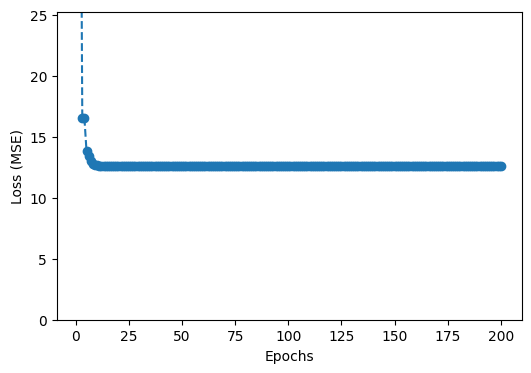

In [47]:
# Plot Loss Function on Training Set
plt.figure(figsize=(6,4))
plt.scatter(range(1,epochs+1),loss_train)
plt.plot(range(1,epochs+1),loss_train,ls="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
ymedian = np.median(loss_train)
#plt.xlim(0,200)
plt.ylim(0,ymedian*2)
plt.show()

In [48]:
################################################################################
# Evaluate model
################################################################################

# Loss on Test Set. Predicted vs Real energies
print("Testing model")
loss = 0
ypred = []
ytrue = []
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn(target, predictions)
    ypred.append(predictions)
    ytrue.append(target)
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))


Testing model
Done. Test loss: 13.095865249633789


ValueError: x and y must be the same size

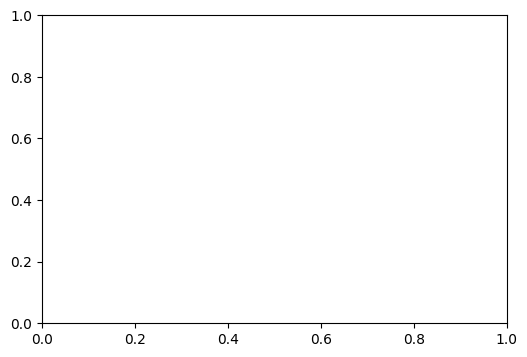

In [49]:
# Plot Predicted vs Real on Test Set

y_pred = np.array(ypred).ravel()
y_true = np.array(ytrue).ravel()

# Convert to original units
#y_pred = np.array(ypred).ravel()#/100
#y_true = np.array(ytrue).ravel()#/100

#E_avrg = -0.025591339035879856
#E_dev = 2.0321151163332116
#y_pred = np.array(ypred).ravel()*E_dev + E_avrg
#y_true = np.array(ytrue).ravel()*E_dev + E_avrg

plt.figure(figsize=(6,4))
plt.scatter(y_true,y_pred,label = "GNN model",color="red")
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.plot(np.linspace(-0.2,0.1,50),np.linspace(-0.2,0.1,50))
plt.xlabel("True Atomic Energy")
plt.ylabel("Pred Atomic Energy")
#plt.xlim(-5,0)
#plt.ylim(-5,0)
plt.title("Test Set")
plt.show()

# mean absolute percentage error (MAPE)
def mape(ytrue, ypred):
    ytrue, ypred = np.array(ytrue), np.array(ypred)
    
    mape_i = np.zeros(len(ytrue))
    mape_i = np.abs((ypred-ytrue)/ytrue)*100
    mape_i = mape_i[ mape_i < 1e6]

    return np.mean(mape_i)

# Compute metrics (MAPE, MAE, MSE)
print("Test MAE:", mean_absolute_error(y_true,y_pred))
print("Test MSE:", mean_squared_error(y_true,y_pred))
print("Test MAPE:", mape(y_true,y_pred))

